In [7]:
from coffea.util import load
import datetime
import matplotlib.pyplot as plt
import mplhep as hep
import yaml
import dill
import pickle
import pandas as pd
from coffea.util import load

plt.style.use('seaborn-v0_8-white')
plt.rcParams['figure.dpi'] = 100#200 # Change for higher resolution
hep.style.use('CMS')

import numpy as np
#from axo_studies import hist_selection, reco_objects, l1_objects
%load_ext autoreload
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
def auto_zoom_x(hist):
    filled = hist.values() > 0
    filled_temp = filled[0][0]
    for i in range(len(filled[0])):
        filled_temp = np.logical_or(filled_temp,filled[0][i])
    
    lowest = np.min(hist.axes.edges[2].flatten()[0:-1][filled_temp])
    highest = np.max(hist.axes.edges[2].flatten()[1:][filled_temp])
    return [lowest, highest]

def label_maker(hist_name):
    label = "None"
    splitted = hist_name.split("_")
    # print("Splitted", splitted)
    prefix = splitted[0:1][0]
    suffix = splitted[-1:][0]
    
    if len(splitted)>2:
        middle=splitted[1:-1][0]
        # print(prefix)
        # print(middle)
        # print(suffix)

            
        if middle in plotting_config["object_label_templates"] and prefix in plotting_config["object_label_templates"]: #di-object
            prefix = plotting_config["object_label_templates"][prefix]
            middle = plotting_config["object_label_templates"][middle]
            label = plotting_config["label_templates"]['diobject'][suffix].format(middle,prefix)
        else:
            prefix = plotting_config["object_label_templates"][prefix]
            label = plotting_config["label_templates"]['object'][suffix].format(prefix,middle)
       
    else:
        if prefix == "l1":
            label = "L1 "+plotting_config["label_templates"]['totals'][suffix]
        elif prefix == "scouting":
            label = "Scouting "+plotting_config["label_templates"]['totals'][suffix]
        elif prefix == "full_reco":
            label = plotting_config["label_templates"]['totals'][suffix]
        elif prefix == "anomaly":
            label = plotting_config["label_templates"]['totals'][hist_name]
        else:
            prefix = plotting_config["object_label_templates"][prefix]
            label = plotting_config["label_templates"]['object_type'][suffix].format(prefix)
        
    # print("Final label:",label)
    return label


def get_trigger_label(trigger,plotting_config):
    label = ""
    split = trigger.split("_")
    if len(split)>3: # orthogonal trigger or purity used 
        if split[0:1][0] == "pure":
            label = plotting_config["trigger_labels"]["_".join(split[2:])]+" pure wrt. "+split[1:2][0]
        else:
            label = plotting_config["trigger_labels"]["_".join(split[0:3])]+" & "+plotting_config["trigger_labels"]["_".join(split[3:])]
    
    if len(split)<=3:
        label = plotting_config["trigger_labels"][trigger]
    return label

def make_the_default_plots(hists, thing_to_plot, plotting_config, df,fig=None,ax=None):
    fig, ax = plt.subplots(figsize=(8,6)) 

    xlabel = label_maker(thing_to_plot)
    for trigger in hist_result[dataset]['trigger']:
        trigger_label = get_trigger_label(trigger,plotting_config)
        utils.draw_hist1d(
                hist_in = hists[thing_to_plot],
                ax=ax,
                trigger=trigger, 
                label=trigger_label, 
                rebin=1, 
                norm=plotting_config["normalized"]
            )

    ax.set_xlim(auto_zoom_x(hists[thing_to_plot]))
    if plotting_config["log_scale"]:
        ax.set_yscale('log')
    ax.set_ylabel(f'Events{" [A.U.]" if plotting_config["normalized"] else ""}', loc='top')
    ax.set_xlabel(xlabel)
    ax.legend(frameon=False)#, fontsize=8)
    hep.cms.label(plotting_config["cms_label"], data=True, lumi=None, year=plotting_config["dataset_titles"][dataset], com=13.6,fontsize=14)

    fig.show()
    fig.savefig(f"plots/{thing_to_plot}_{dataset}_{todays_date}.pdf", format="pdf")

def make_the_purity_plots(hists, thing_to_plot, plotting_config, df,fig=None,ax=None):
            print(thing_to_plot)
            is_obj_i = thing_to_plot.split("_")[1].isdigit() # iterator over 
            if is_obj_i:
                xlabel = label_maker(thing_to_plot)
            else:
                fig, ax = plt.subplots(figsize=(8,6))
                xlabel = label_maker(thing_to_plot)
                
            if thing_to_plot in plotting_config["rebin"]:
                rebin = plotting_config["rebin"][thing_to_plot]
            else:
                rebin = 1
            
            for trigger in hist_result[dataset]['trigger']:
                # Calculate the average purity across all events
                if is_obj_i:
                    trigger_label = label_maker(thing_to_plot)
                else:   
                    trigger_label = get_trigger_label(trigger,plotting_config)
                l = utils.draw_efficiency(
                            hist_in = hists[thing_to_plot],
                            ax=ax,
                            orthogonal_trigger=trigger, 
                            trigger = "pure_L1_"+trigger,
                            label=trigger_label, 
                            rebin=rebin, 
                            norm=plotting_config["normalized"]
                        )
                if "pure" not in trigger:
                    xmin, xmax = ax.get_xlim()
                    average_purity = df.loc["pure_L1_"+trigger]/df.loc[trigger]*100.0
                    color = l[0].get_color()
                    ax.hlines(y=average_purity, xmin=xmin, xmax=xmax,color=color,linestyles='--',label="Mean % unique events")
            ax.set_xlim(auto_zoom_x(hists[thing_to_plot])) 
            ymin, ymax = ax.get_ylim()
            ax.set_ylim((0.0,ymax*1.1))
            #ax.set_ylabel(f'Purity wrt Scouting [%]', loc='top')
            ax.set_ylabel(f'% Unique events wrt L1 ', loc='top')
            #ax.set_xlabel("L1 Jet $p_T$ [GeV]")
            ax.set_xlabel(xlabel)
            handles, labels = ax.get_legend_handles_labels()
            unique_labels = {}
            for handle, label in zip(handles, labels):
                unique_labels[label] = handle  # Keep only the last occurrence
            ax.legend(unique_labels.values(), unique_labels.keys(),frameon=False)
            #ax.legend(frameon=False)#, fontsize=8)
            hep.cms.label(plotting_config["cms_label"], data=True, lumi=None, year=plotting_config["dataset_titles"][dataset], com=13.6,fontsize=14)
        
            fig.show()
            fig.savefig(f"plots/{thing_to_plot}_{dataset}_{todays_date}.pdf", format="pdf")

def make_the_efficiency_plots(hists, thing_to_plot, plotting_config, df,fig=None,ax=None):

    fig, ax = plt.subplots(figsize=(8,6))
    xlabel = label_maker(thing_to_plot)
    
    for trigger in hist_result[dataset]['trigger']:
        if trigger != config['orthogonal_trigger']:
            trigger_label = get_trigger_label(trigger,plotting_config)
            l = utils.draw_efficiency(
                    hist_in = hists[thing_to_plot],
                    ax=ax,
                    orthogonal_trigger=config['orthogonal_trigger'], 
                    trigger = trigger,
                    label=trigger_label, 
                    rebin=5, 
                    norm=plotting_config["normalized"]
                )
    
        ax.set_xlim(auto_zoom_x(hists[thing_to_plot]))
        ax.set_ylabel(f'Efficiency [%]', loc='top')
        ax.set_xlabel(xlabel)

        xmin, xmax = ax.get_xlim()
        ax.hlines(y=100, xmin=xmin, xmax=xmax,color='gray',linestyles='--')
        if not plotting_config["log_scale"]:
            ymin, ymax = ax.get_ylim()
            ax.set_ylim((0.0,ymax*1.1))
        hep.cms.label(plotting_config["cms_label"], data=True, lumi=None, year=plotting_config["dataset_titles"][dataset], com=13.6,fontsize=14)

        handles, labels = ax.get_legend_handles_labels()
        unique_labels = {}
        for handle, label in zip(handles, labels):
            unique_labels[label] = handle  # Keep only the last occurrence
        ax.legend(unique_labels.values(), unique_labels.keys(),frameon=False)
        fig.show()
        fig.savefig(f"plots/{thing_to_plot}_{dataset}_{todays_date}.pdf", format="pdf")

def make_the_ratio_efficiency_plots(hists, thing_to_plot, plotting_config, df,fig=None,ax=None):

    fig, ax = plt.subplots(figsize=(8,6))
    xlabel = label_maker(thing_to_plot)
    triggers = ["DST_PFScouting_ZeroBias_DST_PFScouting_AXONominal","DST_PFScouting_ZeroBias_all_l1_triggers"]
    
    trigger_labels = [get_trigger_label(triggers[0],plotting_config), get_trigger_label(triggers[1],plotting_config)]
    l = utils.draw_efficiency_ratios(
            hist_in = hists[thing_to_plot],
            ax=ax,
            orthogonal_trigger=config['orthogonal_trigger'], 
            triggers = triggers,
            labels=trigger_labels, 
            rebin=5, 
            norm=plotting_config["normalized"]
        )
    
    ax.set_xlim(auto_zoom_x(hists[thing_to_plot]))
    ax.set_ylabel(f'Efficiency Ratio [%]', loc='top')
    ax.set_xlabel(xlabel)

    xmin, xmax = ax.get_xlim()
    #ax.hlines(y=100, xmin=xmin, xmax=xmax,color='gray',linestyles='--')
    if not plotting_config["log_scale"]:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim((0.0,ymax*1.1))
    hep.cms.label(plotting_config["cms_label"], data=True, lumi=None, year=plotting_config["dataset_titles"][dataset], com=13.6,fontsize=14)

    handles, labels = ax.get_legend_handles_labels()
    unique_labels = {}
    for handle, label in zip(handles, labels):
        unique_labels[label] = handle  # Keep only the last occurrence
    ax.legend(unique_labels.values(), unique_labels.keys(),frameon=False)
    fig.show()
    fig.savefig(f"plots/{thing_to_plot}_{dataset}_{todays_date}.pdf", format="pdf")

def make_the_right_plot(hists, thing_to_plot, module, plotting_config,df,fig=None,ax=None):
    if module == "default":
        make_the_default_plots(hists, thing_to_plot, plotting_config,df,fig,ax)
    elif module == "efficiency":
        make_the_efficiency_plots(hists, thing_to_plot, plotting_config,df,fig,ax)
        make_the_ratio_efficiency_plots(hists, thing_to_plot, plotting_config,df,fig,ax)
    elif module == "purity":
        make_the_purity_plots(hists, thing_to_plot, plotting_config,df,fig,ax)
    elif module == "pileup":
        make_the_pileup_plots(hists, thing_to_plot, plotting_config,df,fig,ax)
    return

def run_the_plotloop(config, plotting_config, data, df):
    dataset_name = config['dataset_name']
    hists = data[dataset_name]["hists"]
    
    for histogram_group, histograms in config["histograms_1d"].items():
        print("Histogram group: ", histogram_group)
        
        if histogram_group == "per_event": # event level histograms
            for histogram in histograms:
                print("Histogram type: ",histogram)
                if histogram == "anomaly_score":
                    
                    make_the_right_plot(hists, histogram, config["module"], plotting_config, df)
                else: 
                    for reconstruction_level in config["objects"]:
                        print("Reconstruction level: ",reconstruction_level)
                        make_the_right_plot(hists, reconstruction_level+"_"+histogram, config["module"], plotting_config, df)
                        
        if histogram_group == "per_object_type" or histogram_group == "per_object": # object level histograms 
            for reconstruction_level, object_types in config["objects"].items(): 
                for object_type in object_types:
                    print("Object type:",object_type)

                    # Apply object level cleaning
                    for histogram in histograms:
                        print("Histogram type: ",histogram)
                        
                        if histogram_group == "per_object_type":  
                            make_the_right_plot(hists, object_type+"_"+histogram, config["module"], plotting_config, df)

                        if histogram_group == "per_object": 
                            
                            for i in range(config["objects_max_i"][object_type]):
                                if i%4 == 0:
                                    fig, ax = plt.subplots(figsize=(8,6))
                                make_the_right_plot(hists, object_type+"_"+str(i)+"_"+histogram, config["module"], plotting_config, df,fig,ax)
                                
        elif histogram_group == "per_diobject_pair": # di-object masses etc 
            for reconstruction_level, pairings in config["diobject_pairings"].items():
                for pairing in pairings:
                    print("Pairing:",pairing)
                    object_type_1 = pairing[0]
                    object_type_2 = pairing[1]
                    for histogram in histograms:
                        print("Histogram type: ",histogram)
                        make_the_right_plot(hists, f"{object_type_1}_{object_type_2}_{histogram}", config["module"], plotting_config, df)

    return 

def print_out(data):
    print("Available triggers:")  
    for trigger in data['trigger']:
        print("- "+trigger)
    
    print("\nAvailable histograms:")
    for hist in data['hists']:
        print("- "+hist)
    return

hist_result_2024I_20250228.pkl
Available triggers:
- all_l1_triggers
- DST_PFScouting_AXONominal
- DST_PFScouting_ZeroBias_all_l1_triggers
- DST_PFScouting_ZeroBias_DST_PFScouting_AXONominal
- DST_PFScouting_ZeroBias

Available histograms:
- l1_ht
- l1_met
Histogram group:  per_event
Histogram type:  ht
Reconstruction level:  l1
Histogram type:  met
Reconstruction level:  l1


,Events
start,898310518
DST_PFScouting_ZeroBias,230139714
DST_PFScouting_ZeroBias_all_l1_triggers,7058269
DST_PFScouting_ZeroBias_DST_PFScouting_AXONominal,7085


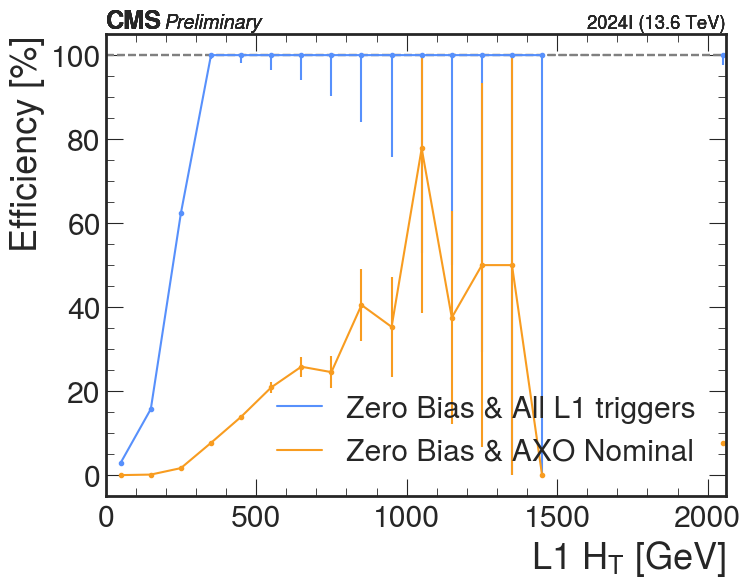

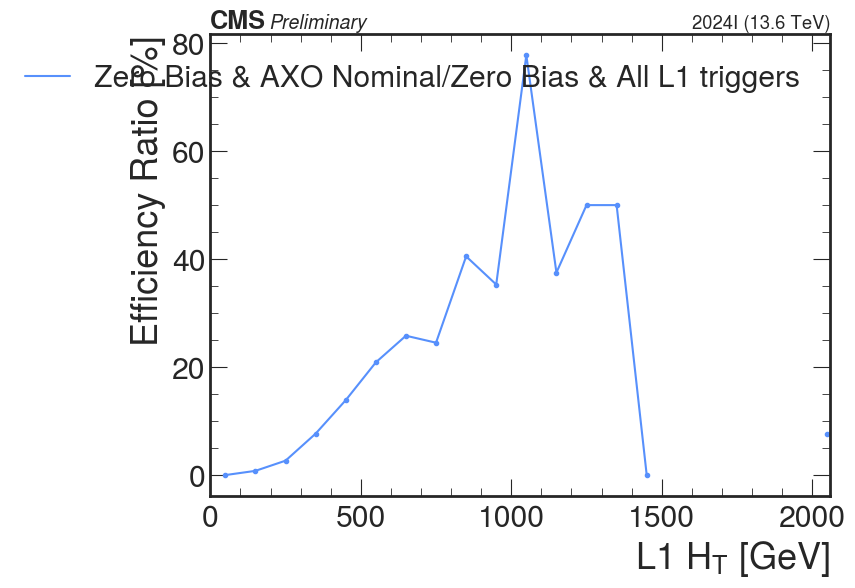

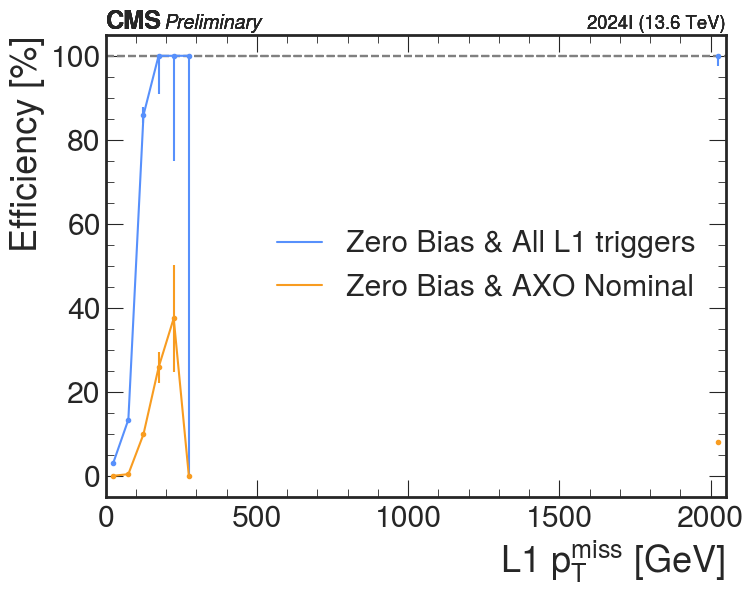

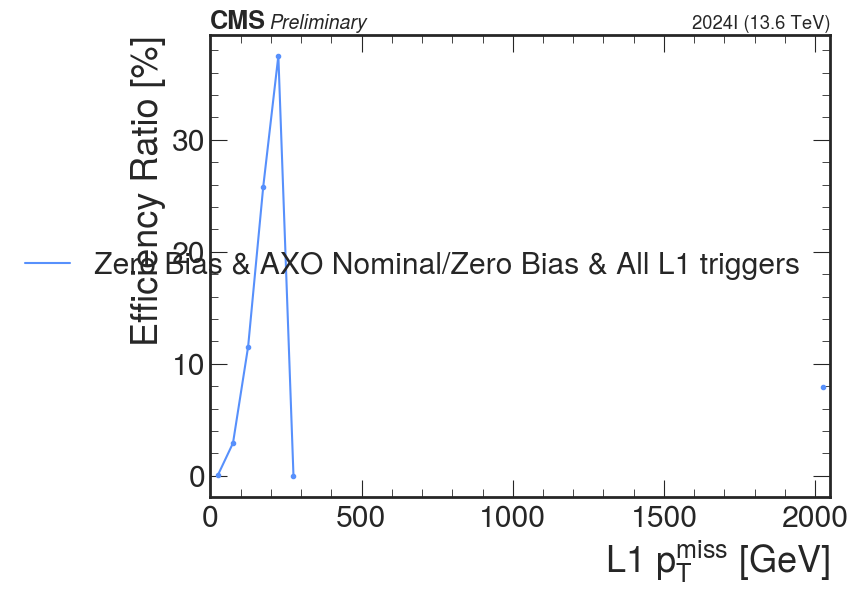

In [33]:

config_filename = "config.yaml"
plotting_config_filename = "plotting_config.yaml"
                                            
with open(config_filename, 'r') as stream:
    config = yaml.safe_load(stream)
with open(plotting_config_filename, 'r') as stream:
    plotting_config = yaml.safe_load(stream)
    
dataset = config["dataset_name"]
todays_date = datetime.date.today().strftime('%Y%m%d')
# dataset = "2024I"
#todays_date = "20250227"

hist_result_filename = f'hist_result_{dataset}_{todays_date}.pkl'          # file name containing histograms
#hist_result_filename = f'hist_result_{dataset}_{20250224}_nocuts.pkl'          # file name containing histograms
print(hist_result_filename )
 # load file with histograms
with open(hist_result_filename, 'rb') as file:
    hist_result = load(file)
    # hist_result = dill.load(file)
    # hist_result = pickle.load(file) #muahahhahaah
    
print_out(hist_result[dataset])

# Get the cutflow
cutflow = hist_result[dataset]['cutflow']
cutflow_merged = {k: v for d in cutflow for k, v in d.items()}
df = pd.DataFrame.from_dict(cutflow_merged,orient="index", columns=["Events"])

run_the_plotloop(config, plotting_config, hist_result,df)

df